# Clustering Methods Implemented on Theoretical Data

## Import Cell

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import math
import time
import sys
import sklearn
warnings.filterwarnings('ignore')

from sys import maxsize
from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.neighbors import NearestNeighbors, kneighbors_graph
from sklearn.datasets import make_regression
from itertools import cycle, islice
from math import degrees, atan2
from kneed import KneeLocator

## Global Parameters Cell

In [2]:
# NO MANUAL INPUT IS REQUIRED BY THE USER BEYOND THIS CELL
np.random.seed(0) #INT SET SEED FOR CONSISTENCY
population = 500 #INT SET SAMPLE SIZE OF ALL DISTRIBUTIONS
random_state = 2 #INT SET SEED FOR CLUSTERING METHODS
max_clusterNum = 17 #INT SET MAX CLUSTER NUM TO ESTIMATE PARAMETERS FOR // AFFECTS NOTEBOOK RUN TIME
dissSensitivity = 0 #FLOAT SET AGNES AND DBSCAN SENSITIVITY

## Parameter Estimation Functions

### AGNES : Dissimilarity Limit Estimation Cell

In [3]:
def get_agnes_threshold(X): # PARAMETER ESTIMATION FOR DISSIMILARITY THRESHOLD
    #//////////////////////////////////#
    #//////////////////////////////////#
    testAGNES = cluster.AgglomerativeClustering(affinity = 'euclidean',
                                            linkage = 'average',
                                            compute_distances = True)
    #//////////////////////////////////#
    #//////////////////////////////////#
    testLabel = testAGNES.fit_predict(X)
    #//////////////////////////////////#
    #//////////////////////////////////#
    #//////////////////////////////////#
    heights = testAGNES.distances_
    heights = np.sort(heights, axis = 0)
    #//////////////////////////////////#
    #//////////////////////////////////#
    kneedle = KneeLocator(range(1,population), 
                          heights[::-1],
                          S=dissSensitivity, #SENSITIVITY,
                          curve="convex",
                          direction="decreasing")
    return kneedle.knee_y
    

### K-Means : Cluster Quantity Estimation Cell

In [4]:
def get_kmeans_cluster_num(X): # PARAMETER ESTIMATION FOR KMEANS CLUSTER QUANTITY
    #//////////////////////////////////#
    score = -2
    output = 2
    #//////////////////////////////////#
    #//////////////////////////////////#
    X = StandardScaler().fit_transform(X)
    #//////////////////////////////////#
    #//////////////////////////////////#
    for quantity in range(2,max_clusterNum): # (MIN, MAX) CLUSTER NUM ITERATIONS TO CHECK
        testKMeans = cluster.KMeans(n_clusters = quantity,
                                    init = 'k-means++',
                                    random_state = random_state)
        
        testLabel = testKMeans.fit_predict(X)
        
        testScore = silhouette_score(X, testLabel, # COMPUTE SILHOUETTE SCORE
                                     metric = 'euclidean')
        if testScore > score:
            score = testScore
            output = quantity
    #//////////////////////////////////#      
    return output    

### DBSCAN : Epsilon Estimation Cell

In [5]:
def get_dbscan_eps(X): # PARAMETER ESTIMATION FOR DBSCAN EPSILON
    #//////////////////////////////////#
    #//////////////////////////////////#
    nbrs = NearestNeighbors(n_neighbors = 2, metric = 'euclidean')
    nbrs = nbrs.fit(X)

    dist,indices = nbrs.kneighbors(X)
    dist = np.sort(dist, axis = 0)
    dist = dist[:,1]
    kneedle = KneeLocator(range(1,population + 1),
                      dist[::-1], # y values
                      S=dissSensitivity, #SENSITIVITY
                      curve="convex",
                      direction="decreasing")
    return kneedle.knee_y

### BIRCH : Cluster Quantity Estimation Cell

In [6]:
def get_birch_cluster_num(X): # PARAMETER ESTIMATION FOR BIRCH CLUSTER QUANTITY
    #//////////////////////////////////#
    score = -2
    output = 2
    #//////////////////////////////////#
    #//////////////////////////////////#
    X = StandardScaler().fit_transform(X)
    #//////////////////////////////////#
    #//////////////////////////////////#
    for quantity in range(2,max_clusterNum): # (MIN, MAX) CLUSTER NUM ITERATIONS TO CHECK
        testBirch = cluster.Birch(n_clusters = quantity)
        testLabel = testBirch.fit_predict(X)
        
        testScore = silhouette_score(X, testLabel,
                                     metric = 'euclidean')
        if testScore > score:
            score = testScore
            output = quantity
    #//////////////////////////////////#
    return output    

### GMM : Cluster Quantity Estimation Cell

In [7]:
def get_gaussian_cluster_num(X): # PARAMETER ESTIMATION FOR GMM CLUSTER QUANTITY
    #//////////////////////////////////#
    score = sys.maxsize
    output = 0
    #//////////////////////////////////#
    #//////////////////////////////////#
    X = StandardScaler().fit_transform(X)
    #//////////////////////////////////#
    #//////////////////////////////////#
    for quantity in range(2,max_clusterNum): # (MIN, MAX) CLUSTER NUM ITERATIONS TO CHECK
        testGaussian = mixture.GaussianMixture(n_components = quantity,
                                               covariance_type = 'full',
                                               max_iter = 150,
                                               random_state = random_state).fit(X)
        
        testScore = testGaussian.bic(X)
        
        if testScore < score: # LESS BIC IS PREFERRED
            score = testScore
            output = quantity
    #//////////////////////////////////#
    return output  

## Test Distribution Preparation

### Type : Rings

In [8]:
#//////////////////////////////////#
rings = datasets.make_circles(n_samples = population,
                              noise = 0.05,
                              factor = 0.5)
#//////////////////////////////////#

### Type: Eye

In [9]:
#//////////////////////////////////#
eye = datasets.make_circles(n_samples = population,
                              noise = 0.05,
                              factor = 0.1)
#//////////////////////////////////#

### Type: Crescents

In [10]:
#//////////////////////////////////#
crescents = datasets.make_moons(n_samples = population,
                                noise = 0.05)
#//////////////////////////////////#

### Type: Streaks

In [11]:
#//////////////////////////////////#
X, y = datasets.make_blobs(n_samples = population,
                           random_state = 189,
                           centers = 4)
#//////////////////////////////////#
#//////////////////////////////////#
streaks = (np.dot(X, [[0.6, -0.6], [-0.4, 0.8]]), y)
#//////////////////////////////////#

### Type: Cross

In [12]:
#//////////////////////////////////#
X, y = make_regression(n_samples=int(population/2),
                       n_features=2,
                       noise=0.01,
                       random_state= random_state)

X, y  = (np.dot(X, [[0.5, -0.7], [-0.4, 0.8]]), y)
#//////////////////////////////////#
#//////////////////////////////////#
X2, y2 = make_regression(n_samples=int(population/2),
                         n_features=2, noise=0.01,
                         random_state= random_state)

X2, y2  = (np.dot(X2, [[0.5, -0.7], [-0.4, 0.8]]), y2)
#//////////////////////////////////#
#//////////////////////////////////#
for x in X2: x[0] = -x[0]
#//////////////////////////////////#
#//////////////////////////////////#

streakI = X, y
streakII = X2, y2
cross = (np.concatenate((streakI[0], streakII[0])),
         np.concatenate((streakI[1], streakII[1])))
#//////////////////////////////////#

### Type: Strict Blobs

In [13]:
#//////////////////////////////////#
strict = datasets.make_blobs(n_samples = population,
                             random_state = 42)
#//////////////////////////////////#

### Type: Lax Blobs

In [14]:
#//////////////////////////////////#
lax = datasets.make_blobs(n_samples=population,
                             cluster_std=[1.0, 2.5, 0.5],
                             random_state=176)
#//////////////////////////////////#

### Type: Uniform 

In [15]:
#//////////////////////////////////#
uniform = np.random.rand(population, 2), None
#//////////////////////////////////#

## Test Distributions Presentation Cell

<function matplotlib.pyplot.show(close=None, block=None)>

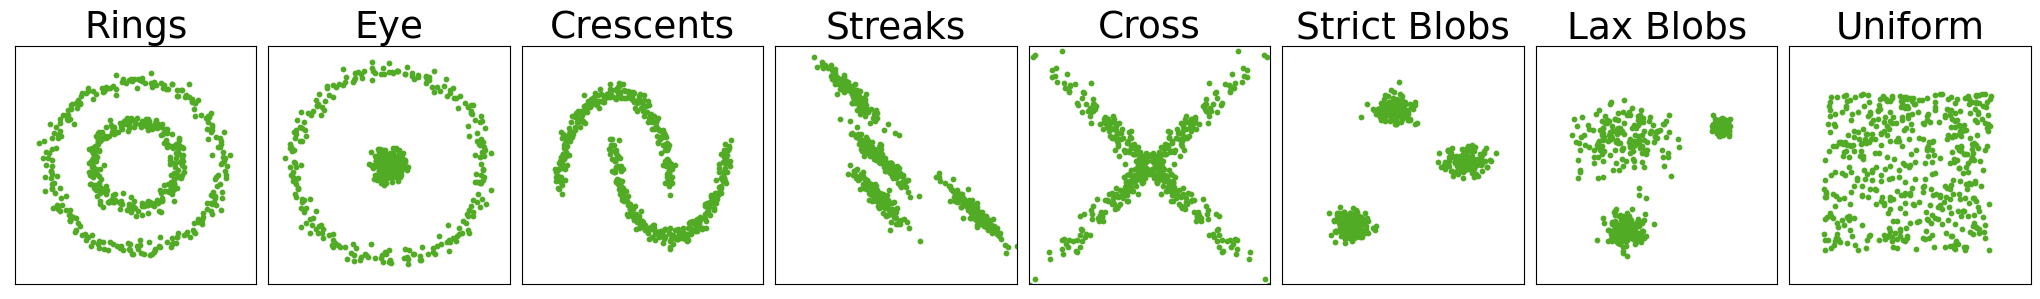

In [16]:
#//////////////////////////////////#
plot_num = 1
plt.figure(figsize=(21, 12.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)
#//////////////////////////////////#
#//////////////////////////////////#
datasetList = [(rings, 'Rings'), # EXCLUDE ONE LINE TO EXCLUDE DATASET FROM TESTING
            (eye, 'Eye'),
            (crescents,'Crescents'),
            (streaks,'Streaks'),
            (cross, 'Cross'),
            (strict,'Strict Blobs'),
            (lax,'Lax Blobs'),
            (uniform,'Uniform')]
#//////////////////////////////////#
#//////////////////////////////////#
for iter_dataset, (dataset ,name) in enumerate(datasetList): # FIRST DISPLAY DATASETS
    X, y = dataset
    X = StandardScaler().fit_transform(X)
    plt.subplot(5, len(datasetList), plot_num)
    plt.scatter(X[:, 0], X[:, 1], s = 10, color = '#51ab24')
    plt.xlim(-2.5, 2.5)
    plt.ylim(-2.5, 2.5)
    plt.xticks(())
    plt.yticks(())
    plt.title(name, size = 27)
    plot_num += 1
#//////////////////////////////////#
#//////////////////////////////////#
plt.show
#//////////////////////////////////#

## Clustering Methods Application Cell

<function matplotlib.pyplot.show(close=None, block=None)>

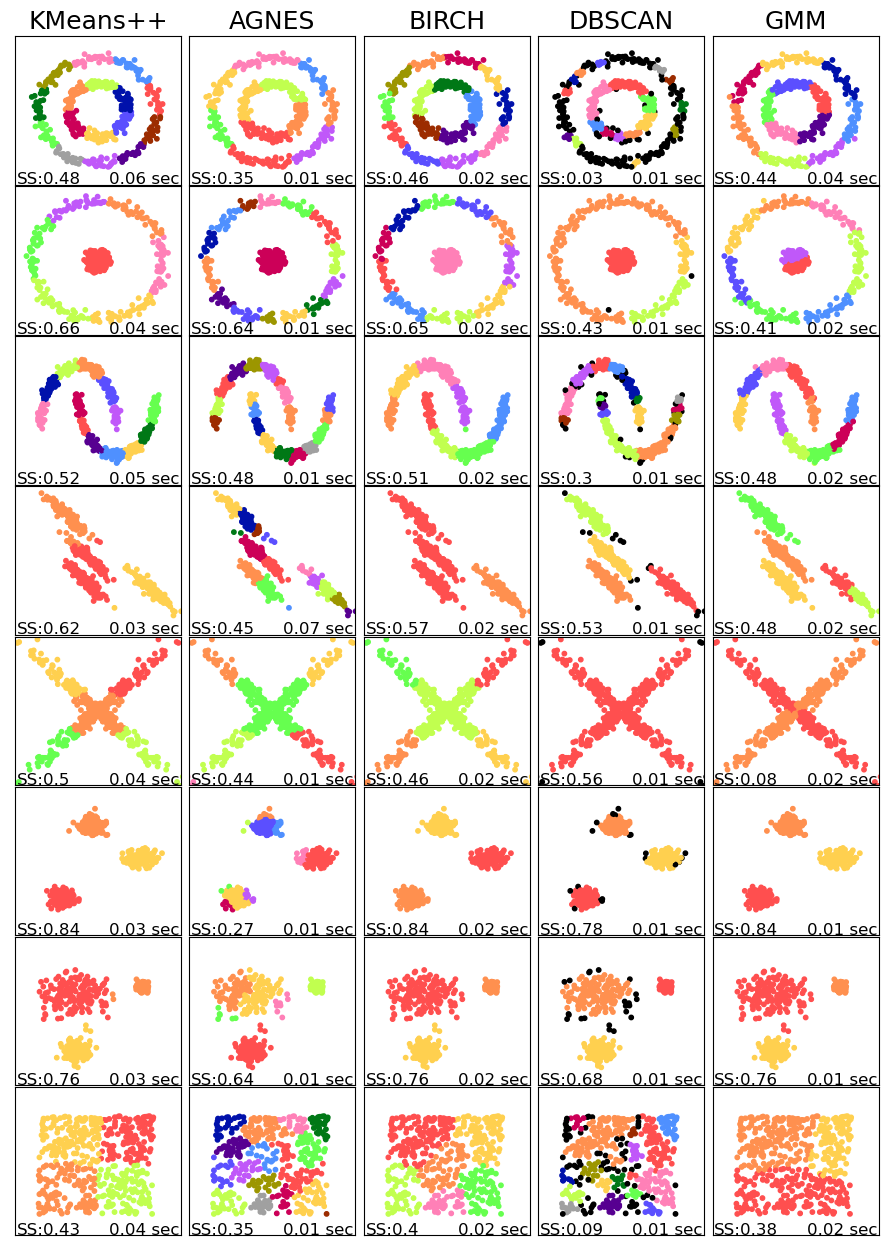

In [17]:
#//////////////////////////////////#
plot_num = 1
plt.figure(figsize=(9, 12.5))
plt.subplots_adjust(left=.02,
                    right=.98,
                    bottom=.001,
                    top=.96,
                    wspace=.05,
                    hspace=.01)
#//////////////////////////////////#
#//////////////////////////////////#
for iter_dataset, (dataset ,params) in enumerate(datasetList): # SECOND DISPLAY POST CLUSTERING
    X, y = dataset
    X = StandardScaler().fit_transform(X)
    
    

    #------------METHOD DECLARATION------------#
    #//////////////////////////////////#
    kMeans = cluster.KMeans(n_clusters = get_kmeans_cluster_num(X),
                            init = 'k-means++',
                            random_state = random_state)
    #//////////////////////////////////#
    #//////////////////////////////////#
    agnes = cluster.AgglomerativeClustering(distance_threshold = get_agnes_threshold(X),
                                            n_clusters = None,
                                            affinity = 'euclidean',
                                            linkage = 'average')
    #//////////////////////////////////#
    #//////////////////////////////////#
    dbscan = cluster.DBSCAN(eps = get_dbscan_eps(X),
                            min_samples = int(round(np.log(population))))
    #//////////////////////////////////#
    #//////////////////////////////////#
    birch = cluster.Birch(n_clusters= get_birch_cluster_num(X))
    #//////////////////////////////////#
    #//////////////////////////////////#
    gaussian = mixture.GaussianMixture(n_components = get_gaussian_cluster_num(X),
                                       covariance_type = 'full',
                                       max_iter = 500,
                                       random_state = random_state)
    #//////////////////////////////////#
    #------------------------------------------#
    #//////////////////////////////////#

    clustering_methods = ( # <<<<<<< EXCLUDE LINE TO EXCLUDE FROM OUTPUT
        ('KMeans++', kMeans),
        ('AGNES', agnes),
        ('BIRCH', birch),
        ('DBSCAN', dbscan),
        ('GMM', gaussian)

        
    )
    #//////////////////////////////////#
    #//////////////////////////////////#
    for methodName, method in clustering_methods:
        tStart = time.time()
        y_predict = method.fit_predict(X)
        
        plt.subplot(len(datasetList),
                    len(clustering_methods),
                    plot_num)
        tEnd = time.time()
        
        if iter_dataset == 0:
            plt.title(methodName,
                      size=18)
            
        colors = np.array(list(islice(cycle(['#ff4f4f', '#ff904f', '#ffd04f',
                                             '#c1ff4f', '#66ff4f', '#ff80b7',
                                             '#c058f9', '#4f90ff', '#5b4fff',
                                             '#cc0058', '#0011ab', '#570091',
                                             '#007816', '#9c9600', '#9c2c00',
                                             '#a0a0a0']),
                                        int(max(y_predict) + 1))))
        colors = np.append(colors, ["#000000"])
        
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_predict])
    #//////////////////////////////////#
    #//////////////////////////////////#
        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        # SILHOUETTE SCORE DISPLAY
        plt.text(.01, .01, 'SS:' + str(np.round(silhouette_score(X, y_predict), decimals = 2)), 
                           transform=plt.gca().transAxes, size=12,
                           horizontalalignment='left')
        # TIME TAKEN DISPLAY
        plt.text(.99, .01, str(np.round(tEnd - tStart, decimals = 2)) + ' sec',
                           transform=plt.gca().transAxes, size=12,
                           horizontalalignment='right')
        
        # METHOD NAME DISPLAY
#        plt.text(.01,.91, methodName,
#                          transform = plt.gca().transAxes, size = 10,
#                          horizontalalignment='left')
        plot_num += 1
    #//////////////////////////////////#
    #//////////////////////////////////#

plt.show

### Framework Reference Cell

In [18]:
#FORMAT
#FOR GRAPH TYPE:
#    FOR METHOD:
#        AUTOMATE PARAMETER SELECTION AND PERFORM

## Automatic Parameter Estimation Demonstration

### K-Means Silhouette Score Cluster Quantity Estimation Demonstration

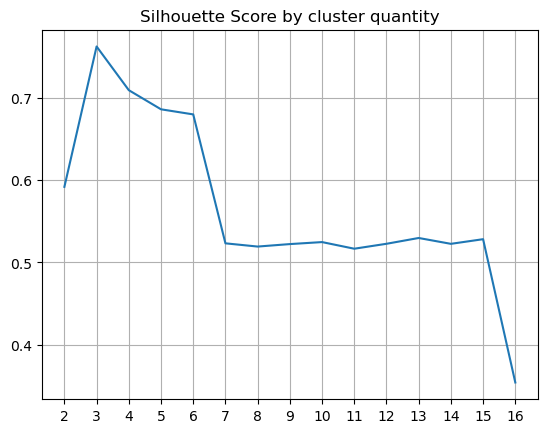

Best score attained at 3 clusters: 0.7629888537773648


In [19]:
#//////////////////////////////////#
clusterNum = [str(i) for i in range(2,max_clusterNum)] 
#//////////////////////////////////#
#//////////////////////////////////#
scores = []
#//////////////////////////////////#
#//////////////////////////////////#
score = -2
output = 2 
#//////////////////////////////////#
#//////////////////////////////////#
X, y = lax   
X = StandardScaler().fit_transform(X)
#//////////////////////////////////#
#//////////////////////////////////#
for quantity in range(2,max_clusterNum): # (MIN, MAX) CLUSTER NUM ITERATIONS TO CHECK
    testKMeans = cluster.KMeans(n_clusters = quantity,
                                    init = 'k-means++',
                                    random_state = random_state)
    
    testLabel = testKMeans.fit_predict(X)
        
    testScore = silhouette_score(X,
                                 testLabel,
                                 metric = 'euclidean')
    scores.append(testScore)
    if testScore > score: # IF SILHOUETTE SCORE IS HIGHER;
        score = testScore # UPDATE HIGHEST SILHOUETTE SCORE
        output = quantity # UPDATE CORRESPONDING CLUSTER NUMBER
#//////////////////////////////////#
#//////////////////////////////////#
plt.plot(clusterNum,scores)
plt.grid()
plt.title('Silhouette Score by cluster quantity')
plt.xticks()
plt.yticks()
plt.show()
#//////////////////////////////////#
#//////////////////////////////////#
print('Best score attained at ' + str(output) + ' clusters: ' + str(score))
#//////////////////////////////////#


### AGNES Dissimilarity Threshold Estimation Demonstration

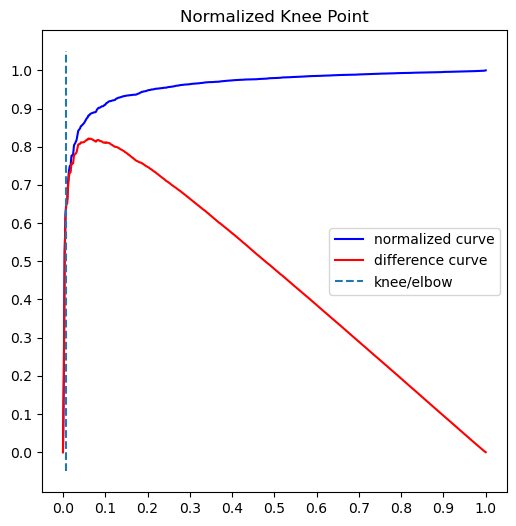

In [20]:
#//////////////////////////////////#
testAGNES = cluster.AgglomerativeClustering(affinity = 'euclidean',
                                            linkage = 'average',
                                            compute_distances = True)
#//////////////////////////////////#
#//////////////////////////////////#
testLabel = testAGNES.fit_predict(X)
#//////////////////////////////////#
#//////////////////////////////////#
#//////////////////////////////////#
heights = testAGNES.distances_
heights = np.sort(heights, axis = 0)
#//////////////////////////////////#
#//////////////////////////////////#
kneedle = KneeLocator(range(1,population),
                      heights[::-1],
                      S=dissSensitivity, #SENSITIVITY
                      curve="convex",
                      direction="decreasing")

kneedle.plot_knee_normalized()
#//////////////////////////////////#
#//////////////////////////////////#

In [21]:
kneedle.knee_y

0.8578374912666649

### DBSCAN Epsilon Estimation Demonstration

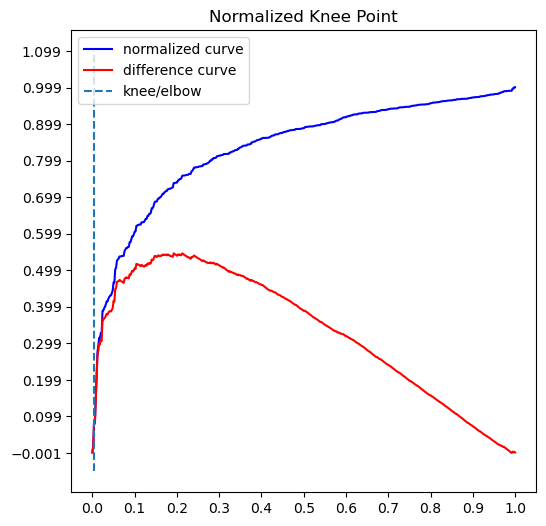

In [22]:
#//////////////////////////////////#
Xdb, ydb = lax
Xdb = StandardScaler().fit_transform(Xdb)
#//////////////////////////////////#
#//////////////////////////////////#
nbrs = NearestNeighbors(n_neighbors = 2, metric = 'euclidean')
nbrs = nbrs.fit(Xdb)

dist,indices = nbrs.kneighbors(Xdb)
dist = np.sort(dist, axis = 0)
dist = dist[:,1]
#//////////////////////////////////#
#//////////////////////////////////#
kneedle = KneeLocator(range(1,population + 1),
                      dist[::-1],
                      S=dissSensitivity, #SENSITIVITY
                      curve="convex", 
                      direction="decreasing") 

kneedle.plot_knee_normalized()
#//////////////////////////////////#
#//////////////////////////////////#

In [23]:
kneedle.knee_y

0.22648529598435543

### GMM BIC Estimation Demonstration

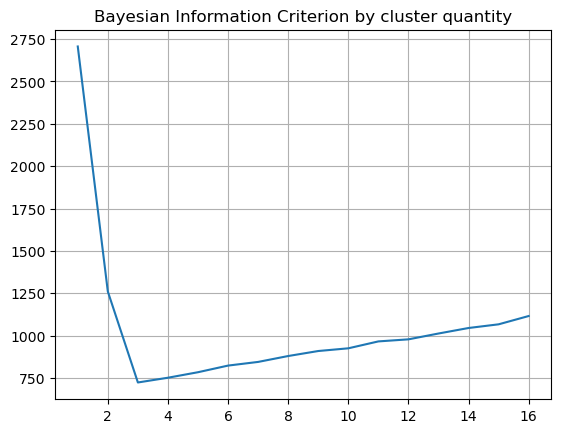

Optimal cluster quantity: 3
Corresponding to BIC value: 723.0707167510374


In [24]:
#//////////////////////////////////#
n_clusters = range(1,max_clusterNum) # (MIN, MAX) CLUSTER NUM ITERATIONS TO CHECK
#//////////////////////////////////#
#//////////////////////////////////#
gsM = [mixture.GaussianMixture(n,
                               covariance_type = 'full',
                               random_state = random_state)
                               .fit(X) for n in n_clusters]
#//////////////////////////////////#
#//////////////////////////////////#
plt.plot(n_clusters, [m.bic(X) for m in gsM], label = 'BIC')

plt.title('Bayesian Information Criterion by cluster quantity')
plt.xticks()
plt.yticks()
plt.grid()
plt.show()
#//////////////////////////////////#
#//////////////////////////////////#
BIC = sys.maxsize
for index in range(len(gsM)):
    bicAtIndex = gsM[index].bic(X)
    if bicAtIndex <= BIC:
        BIC = bicAtIndex
        optK = index + 1
#//////////////////////////////////#
#//////////////////////////////////#
print("Optimal cluster quantity: " + str(optK) + "\n" +
      "Corresponding to BIC value: " + str(BIC))
 #//////////////////////////////////#